# *0*. Top level


Code in this file *should* be robust against card images being re-downloaded/re-copied/otherwise generally messed up. Unfortunately, the way this is implemented is rather slow: it checks for each file to be loaded or saved and performs the desired operation if it does not exist. So, expect a long run time.

**Work Flow**

Note that the workflow as currently set up assumes that, if you are working in Google Colab, your working directory is `/content/drive/My Drive/Colab Notebooks/YGO`. You can change this in the next chunk if you need to.

1.   Load or create card data objects. This requires a file named `cardinfo.php` in `./data/`.
  *   This process results in objects named `data`, `df` (a `Pandas` `DataFrame`), and `df_large` (a `Pandas` `DataFrame`).
  *   If you wish to call `make_model()` (below), you *must* have two `Pandas` `DataFrame`s of card data named `df` and `df_large` saved to `.pkl` files in `./data/`.
2.   Download & crop *or* verify the existence of every *unsorted* card image (cropped & uncropped) in `./unsorted_cards/`.
3. For every network `net`:
  *   Call `move_card_images()` to copy card images from `./unsorted_cards/` to class-named folders within `./sorted_cards/net/` (or verify existence).
  *   Call `settings()` to create a `settings` object with settings for network.
4. If a `model_output`-type object named `out_net` exists in `./data/` (as a `.pkl`), load it. If not:
  *   Call `settings.generate_data_loaders()` to create data loaders for the model *as attributes of `settings`*. Note that this method takes no arguments, will take a moment to complete, and modifies `settings` **in place**.
  *   Call `make_model()` to create a `model`. `make_model()` takes arguments including `settings=`, which requires a `settings` object with already-generated data loaders.
  *   Call `model.run_train()`, which returns an object of class `model_output` with loss and accuracy values from training/validation.
5.   Create plots for loss \& accuracy.
  *   These save to `./report/figures/` with names `loss[num].jpg` and `accuracy[num].jpg`, respectively, where `[num]` is either None (all experiments' lines full-alpha) or 1-4 (one experiment's line full-alpha, others' lower-alpha). These **will be overwritten** if the code is run again.

Notes
  *   Every run of a network saves a `model_output`-type object named `out_net` in `./data/` (as a `.pkl`).
  *   Running the network again requires manually deleting its `out_net` file in `./data/`. This is intended behavior.
  *   Every run also writes to a `.txt` file named `net.txt` in `./out/`. This file **will be overwritten** (with a printed warning) if the network is run again.






In [ ]:
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

  Using cached https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
  Created wheel for torchsampler: filename=torchsampler-0.1.1-cp37-none-any.whl size=3789 sha256=56a50c2fb7f793cd8849a4804fef78eee019b15054a624c11a84850d5da472e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-gce60ycj/wheels/c1/f1/dc/587588aa0a5f0dc76673d98a554ff4db2575aaca3984240ec1
Successfully built torchsampler


In [ ]:
#%%capture
import json, shutil, requests, textwrap, torch, torchvision, os, pickle

from torchvision import transforms
from torchsampler import ImbalancedDatasetSampler
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if 'google.colab' in str(get_ipython()):
  currentDir = os.path.join("/", "content", "drive", "My Drive", "Colab Notebooks", "YGO")
else:
  currentDir = os.getcwd()

os.chdir(os.path.join(currentDir, "scripts"))
from image_funcs import ImageDl, progress_update, make_splits, move_card_images, update_filenames, crop_image
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from wrappers import settings, model_output, make_model

os.chdir(os.path.dirname(os.getcwd()))

currentDir = os.getcwd()

print("Current working directory: ")
!pwd

# *1*. Card data

In [ ]:
# Dictionary with card data
data = json.load(open(os.path.join(currentDir, "data", "cardinfo.php"), "r")) 

# Data frame with all cards
if os.path.exists(os.path.join(currentDir, "data", "data_frame.pkl")):
  df = pd.read_pickle(os.path.join(currentDir, "data", "data_frame.pkl"))
else:
  keys = data["data"][0].keys()
  data_clean = []

  for i in range(len(data["data"])):
      this_record = data["data"][i]
      temp = list()
      for key in keys:
          try:
              temp.append(str(this_record[key]))
          except:
              temp.append("NA")
      data_clean.append(temp)

  df = pd.DataFrame(data_clean, columns=list(keys))
  df = df.convert_dtypes()

  def type_shorten(ty):
    if "Spell" in ty:
      return "Spell"
    elif "Trap" in ty:
      return "Trap"
    else:
      return "Monster"

  df["short_type"] = [type_shorten(i["type"]) for i in data["data"]]
  df["general_type"] = [i.split()[0]+" "+i.split()[-1] for i in df.type]
  for i, t in enumerate(df.general_type):
    if "Token" in t:
      df["general_type"].iloc[i] = "Token"

  df.to_pickle(os.path.join(currentDir, "data", "data_frame.pkl"))

# Data frame with only cards in archetypes with >= 20 cards
if os.path.exists(os.path.join(currentDir, "data", "df_large.pkl")):
  df_large = pd.read_pickle(os.path.join(currentDir, "data", "df_large.pkl"))
else:
  # Count number of cards in archetype
  a = df.drop(df[(df['archetype']=="NA")].index).groupby("archetype").archetype.count()

  # Create list of archetypes with fewer than 20 cards
  one_offs = a[a<20].index.tolist()

  # Keep only archetypes with more than 20 cards
  d_a = []
  for i in range(len(df['archetype'])): 
    if df['archetype'][i] not in one_offs:
      d_a.append(df.loc[i])

  df_large = pd.DataFrame(d_a, columns=df.columns) # Make it a data frame
  df_large = df_large[(df_large.archetype!="NA")] # Remove no-archetype cards
  df_large = df_large.reset_index() # Fix the index

  df_large.to_pickle(os.path.join(currentDir, "data", "df_large.pkl"))

# *2*. Card images (download & crop)

In [ ]:
he = ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '+
      '(KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36')

headers = {'user-agent': he}

# Determine which cards are pendulum cards
# These cards have differently-shaped artwork
pends = ["Pendulum" in df.type[i] for i in range(len(df.type))]
pend_index = df[pends].index

# The x, y coordinates of the areas to be cropped. (x1, y1, x2, y2)
crop_areas_normal = (49, 112, 371, 432)
crop_areas_pend = (27, 110, 394, 382)

# Save images to ./unsorted_cards/Images
path = os.path.join(currentDir, "unsorted_cards", 'Images')

for i in range(len(data["data"])):
    progress_update(i, len(data["data"]))
    
    current_url = data["data"][i]["card_images"][0]["image_url"]
    if not os.path.exists(os.path.join(path, str(current_url.split('/')[-1]))):
      ImageDl(current_url)
    
    current_card = data["data"][i]["card_images"][0]["id"]
    image_name, new_filename = update_filenames(currentDir, current_card)

    if not os.path.exists(new_filename):
      img = Image.open(image_name)
      if i in pend_index:
        crop_image(img, crop_areas_pend, new_filename)
      else:
        crop_image(img, crop_areas_normal, new_filename)

Done!


# *3 & 4*. Models

## Full cards, primary type `_ft`

In [ ]:
# All cards by card type, full
move_card_images("ft", split_on="type", 
                 train_prop=0.8, test_prop=0.1,
                 check_vector=None, cropped=False,
                 rand_seed=453)

Done!


In [ ]:
settings_ft = settings(
      RANDOM_SEED = 453,
      BATCH_SIZE = 32,
      NUM_EPOCHS = 40,
      LEARNING_RATE = 0.0005,
      current_dir = currentDir,
      image_fldr = "ft",
      transform_list = [
        # Min of (H, W) b/t the two pic formats
        #transforms.RandomResizedCrop(size=(272, 322)), 
        transforms.Resize(size=(312, 211)),

        transforms.ColorJitter(
                            brightness=(0.75, 1.5),
                            contrast=(0.75, 1.5),
                            hue=0.1,
                            saturation=(0.75, 1.5)
                            ),
        
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),

        transforms.RandomAffine(
                              degrees=0,
                              translate=(0.2, 0.2), # max (H, W) shift (prop of size)
                              interpolation=transforms.InterpolationMode.BILINEAR,
                              shear=(0, 10,
                                    0, 10),
                              fill=0
                            ),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

In [ ]:
if os.path.exists(os.path.join(currentDir, "data", "out_ft.pkl")):
  with open(os.path.join(currentDir, "data", "out_ft.pkl"), "rb") as pickle_file:
    out_ft = pickle.load(pickle_file)
else:
  # Creates train_loader/valid_loader/test_loader (as attributes of settings)
  settings_ft.generate_data_loaders()
  
  model_ft = make_model(
              model = models.resnet152(pretrained=True),
              settings = settings_ft,
              optimizer = torch.optim.Adam,
              optimizer_args = None,
              scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau,
              scheduler_args = {"factor": 0.2,
                                "mode": "max",
                                "verbose": True},
              scheduler_on='minibatch_loss',
              logging_interval=100
              )

  out_ft = model_ft.run_train()
  with open(os.path.join(currentDir, "data", "out_ft.pkl"), "wb") as pickle_file:
    pickle.dump(out_ft, pickle_file)

## Full card, archetype `_fa`

In [ ]:
# Large archetype cards by archetype, full
move_card_images("fa", split_on="archetype",
                 train_prop=0.6, test_prop=0.2,
                 check_vector=None, cropped=False,
                 rand_seed=453)

Done!


In [ ]:
settings_fa = settings(
      RANDOM_SEED = 453,
      BATCH_SIZE = 32,
      NUM_EPOCHS = 40,
      LEARNING_RATE = 0.0003,
      current_dir = currentDir,
      image_fldr = "fa",
      transform_list = [
        # Min of (H, W) b/t the two pic formats
        #transforms.RandomResizedCrop(size=(272, 322)), 
        transforms.Resize(size=(312, 211)),

        transforms.ColorJitter(
                            brightness=(0.75, 1.5),
                            contrast=(0.75, 1.5),
                            hue=0.1,
                            saturation=(0.75, 1.5)
                            ),
        
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),

        transforms.RandomAffine(
                              degrees=0,
                              translate=(0.2, 0.2), # max (H, W) shift (prop of size)
                              interpolation=transforms.InterpolationMode.BILINEAR,
                              shear=(0, 10,
                                    0, 10),
                              fill=0
                            ),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

In [ ]:
if os.path.exists(os.path.join(currentDir, "data", "out_fa.pkl")):
  with open(os.path.join(currentDir, "data", "out_fa.pkl"), "rb") as pickle_file:
    out_fa = pickle.load(pickle_file)
else:
  # Creates train_loader/valid_loader/test_loader (as attributes of settings)
  settings_fa.generate_data_loaders()
  
  model_fa = make_model(
              model = models.resnet152(pretrained=True),
              settings = settings_fa,
              optimizer = torch.optim.Adam,
              optimizer_args = None,
              scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau,
              scheduler_args = {"factor": 0.2,
                                "mode": "max",
                                "verbose": True},
              scheduler_on='minibatch_loss',
              logging_interval=50
              )

  out_fa = model_fa.run_train()
  with open(os.path.join(currentDir, "data", "out_fa.pkl"), "wb") as pickle_file:
    pickle.dump(out_fa, pickle_file)

## Artwork, primary type `_at`

In [ ]:
# All cards by card type, cropped
move_card_images("at", split_on="type", 
                 train_prop=0.8, test_prop=0.1,
                 check_vector=None, cropped=True,
                 rand_seed=453)

Done!


In [ ]:
settings_at = settings(
      RANDOM_SEED = 453,
      BATCH_SIZE = 32,
      NUM_EPOCHS = 40,
      LEARNING_RATE = 0.0001,
      current_dir = currentDir,
      image_fldr = "at",
      transform_list = [
        # Min of (H, W) b/t the two pic formats
        transforms.RandomResizedCrop(size=(272, 322)), 
        #transforms.Resize(size=(312, 211)),

        transforms.ColorJitter(
                            brightness=(0.75, 1.5),
                            contrast=(0.75, 1.5),
                            hue=0.1,
                            saturation=(0.75, 1.5)
                            ),
        
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),

        transforms.RandomAffine(
                              degrees=0,
                              translate=(0.2, 0.2), # max (H, W) shift (prop of size)
                              interpolation=transforms.InterpolationMode.BILINEAR,
                              shear=(0, 10,
                                    0, 10),
                              fill=0
                            ),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

In [ ]:
if os.path.exists(os.path.join(currentDir, "data", "out_at.pkl")):
  with open(os.path.join(currentDir, "data", "out_at.pkl"), "rb") as pickle_file:
    out_at = pickle.load(pickle_file)
else:
  # Creates train_loader/valid_loader/test_loader (as attributes of settings)
  settings_at.generate_data_loaders()
  
  model_at = make_model(
              model = models.resnet152(pretrained=True),
              settings = settings_at,
              optimizer = torch.optim.Adam,
              optimizer_args = None,
              scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau,
              scheduler_args = {"factor": 0.2,
                                "mode": "max",
                                "verbose": True},
              scheduler_on='minibatch_loss',
              logging_interval=50
              )
  out_at = model_at.run_train()
  with open(os.path.join(currentDir, "data", "out_at.pkl"), "wb") as pickle_file:
    pickle.dump(out_at, pickle_file)

## Artwork, archetype `_aa`

In [ ]:
# Large archetype cards by archetype, cropped
move_card_images("aa", split_on="archetype", 
                 train_prop=0.6, test_prop=0.2,
                 check_vector=None, cropped=True,
                 rand_seed=453)

Done!


In [ ]:
settings_aa = settings(
      RANDOM_SEED = 453,
      BATCH_SIZE = 32,
      NUM_EPOCHS = 40,
      LEARNING_RATE = 0.0001,
      current_dir = currentDir,
      image_fldr = "aa",
      transform_list = [
        # Min of (H, W) b/t the two pic formats
        transforms.RandomResizedCrop(size=(272, 322)), 
        #transforms.Resize(size=(312, 211)),

        transforms.ColorJitter(
                            brightness=(0.75, 1.5),
                            contrast=(0.75, 1.5),
                            hue=0.1,
                            saturation=(0.75, 1.5)
                            ),
        
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),

        transforms.RandomAffine(
                              degrees=0,
                              translate=(0.2, 0.2), # max (H, W) shift (prop of size)
                              interpolation=transforms.InterpolationMode.BILINEAR,
                              shear=(0, 10,
                                    0, 10),
                              fill=0
                            ),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

In [ ]:
if os.path.exists(os.path.join(currentDir, "data", "out_aa.pkl")):
  with open(os.path.join(currentDir, "data", "out_aa.pkl"), "rb") as pickle_file:
    out_aa = pickle.load(pickle_file)
else:
  # Creates train_loader/valid_loader/test_loader (as attributes of settings)
  settings_aa.generate_data_loaders()
  
  model_aa = make_model(
              model = models.resnet152(pretrained=True),
              settings = settings_aa,
              optimizer = torch.optim.Adam,
              optimizer_args = None,
              scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau,
              scheduler_args = {"factor": 0.2,
                                "mode": "max",
                                "verbose": True},
              scheduler_on='minibatch_loss',
              logging_interval=50
              )

  out_aa = model_aa.run_train()
  with open(os.path.join(currentDir, "data", "out_aa.pkl"), "wb") as pickle_file:
    pickle.dump(out_aa, pickle_file)

# *5*. Plot

## Loss

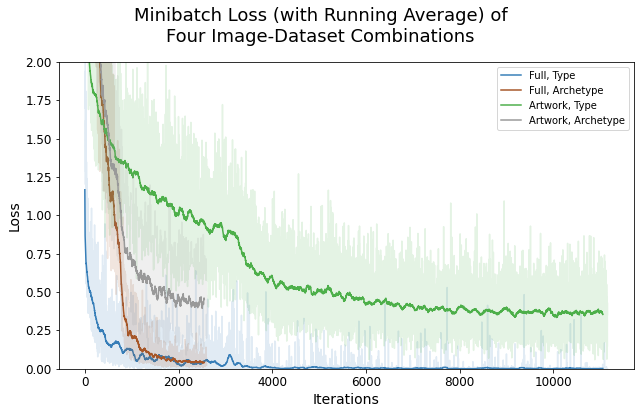

In [ ]:
#### Loss

plt.figure(figsize=(9, 6))
set_list = [settings_ft, settings_fa, settings_at, settings_aa]
name_list = ["Full, Type", "Full, Archetype", "Artwork, Type", "Artwork, Archetype"]
cols = ['#377eb8', 
        '#a65628', 
        '#4daf4a',
        '#999999']

for i, out_obj in enumerate([out_ft, out_fa, out_at, out_aa]):

    settings_current = set_list[i]
    plt.plot(range(len(out_obj.minibatch_loss_list)),
                out_obj.minibatch_loss_list,
                #label=name_list[i],#'Minibatch Loss',
                alpha=0.15,
                color=cols[i])

    if i in [1, 3]:
      l = 50
    else:
      l = 100
  
    plt.plot(np.convolve(out_obj.minibatch_loss_list,
                         np.ones(l,)/l,
                         mode='valid'),
                         label=name_list[i],#'Running Average',
                         color=cols[i])
    plt.ylim([0, 2])
    plt.xlabel('Iterations', fontsize=14)
    plt.xticks(fontsize=12)
    plt.ylabel('Loss', fontsize=14)
    plt.yticks(fontsize=12)
    
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.89])
plt.suptitle("Minibatch Loss (with Running Average) of\nFour Image-Dataset Combinations", fontsize=18)
plt.savefig(os.path.join(currentDir, "report", "figures", "loss.pdf"))
plt.show()

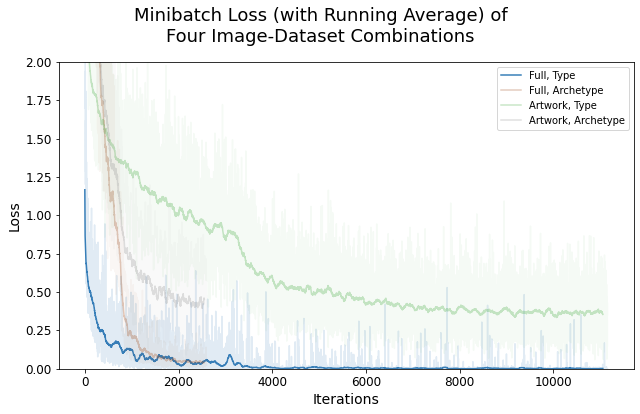

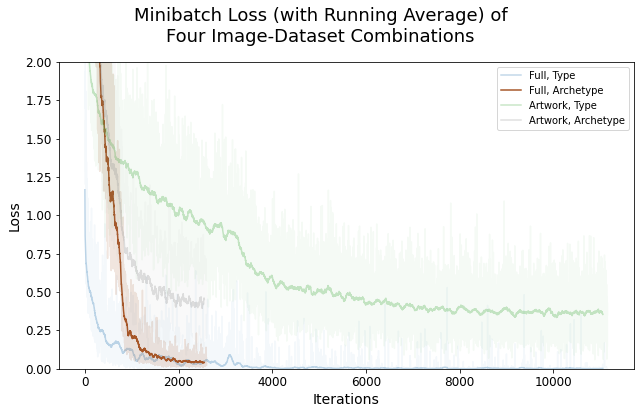

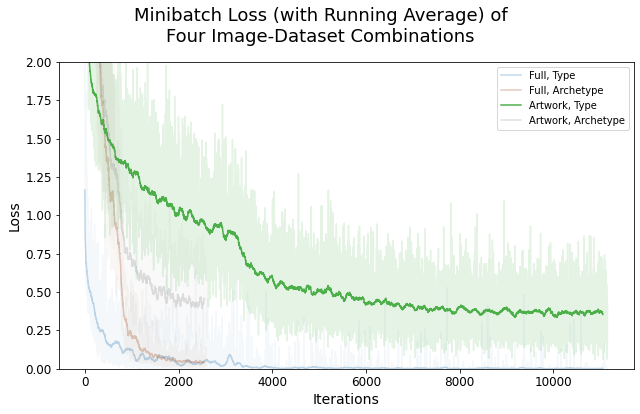

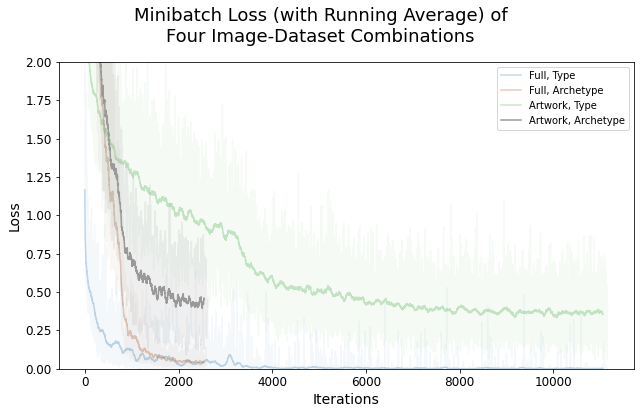

In [ ]:
#### Separate


set_list = [settings_ft, settings_fa, settings_at, settings_aa]
name_list = ["Full, Type", "Full, Archetype", "Artwork, Type", "Artwork, Archetype"]
cols = ['#377eb8', 
        '#a65628', 
        '#4daf4a',
        '#999999']
j = 0
while j < 4:
  plt.figure(figsize=(9, 6))
  for i, out_obj in enumerate([out_ft, out_fa, out_at, out_aa]):
      

      if i==j:
        alp1 = 0.15
        alp2 = 1
      else:
        alp1 = 0.05
        alp2 = 0.3

      settings_current = set_list[i]
      plt.plot(range(len(out_obj.minibatch_loss_list)),
                  out_obj.minibatch_loss_list,
                  #label=name_list[i],#'Minibatch Loss',
                  alpha=alp1,
                  color=cols[i])

      if i in [1, 3]:
        l = 50
      else:
        l = 100
    
      plt.plot(np.convolve(out_obj.minibatch_loss_list,
                          np.ones(l,)/l,
                          mode='valid'),
                          label=name_list[i],#'Running Average',
                          alpha=alp2,
                          color=cols[i])
      plt.ylim([0, 2])
      plt.xlabel('Iterations', fontsize=14)
      plt.xticks(fontsize=12)
      plt.ylabel('Loss', fontsize=14)
      plt.yticks(fontsize=12)
      
  plt.legend()

  plt.tight_layout(rect=[0, 0.03, 1, 0.89])
  plt.suptitle("Minibatch Loss (with Running Average) of\nFour Image-Dataset Combinations", fontsize=18)
  plt.savefig(os.path.join(currentDir, "report", "figures", "loss"+str(j+1)+".pdf"))
  #plt.show()
  j+=1

## Accuracy

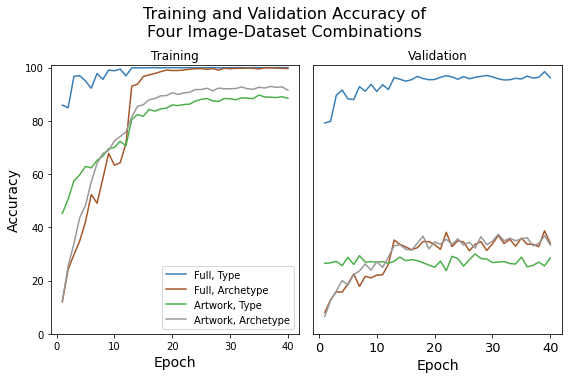

In [ ]:
#### Together

f, ax = plt.subplots(1, 2, figsize=(8, 5.5))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
for i, out_obj in enumerate([out_ft, out_fa, out_at, out_aa]):
    
      num_epochs = len(out_obj.train_acc_list)
      
      ax[0].plot(np.arange(1, num_epochs+1),
              out_obj.train_acc_list,
              label=name_list[i],
              color=cols[i])
      ax[0].set_ylim([0, 101])
      ax[0].set_ylabel('Accuracy', fontsize=14)
      ax[0].set_xlabel("Epoch", fontsize=14)
      ax[0].legend(loc="lower right")
      ax[0].set_title("Training")

      ax[1].plot(np.arange(1, num_epochs+1),
              out_obj.valid_acc_list,
              label=name_list[i],
              color=cols[i])
      ax[1].set_ylim([0, 101])
      ax[1].set_yticks([])
      ax[1].set_xlabel("Epoch", fontsize=14)
      ax[1].set_title("Validation")

f.tight_layout(rect=[0, 0.03, 1, 0.9])
f.suptitle("Training and Validation Accuracy of\nFour Image-Dataset Combinations", fontsize=16)
plt.savefig(os.path.join(currentDir, "report", "figures", "accuracy.pdf"))
f.show()

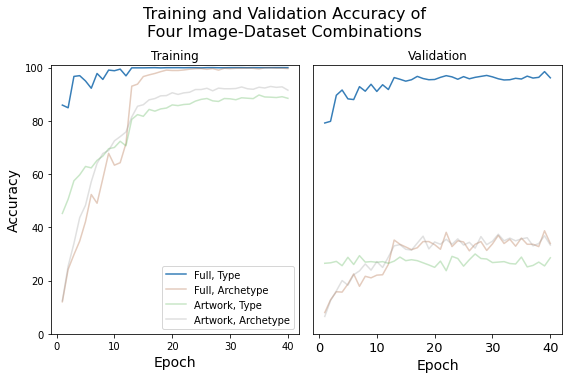

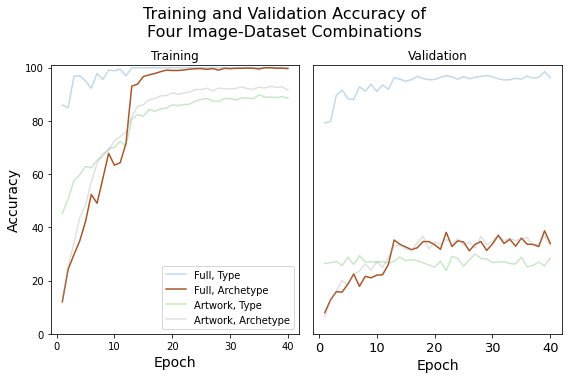

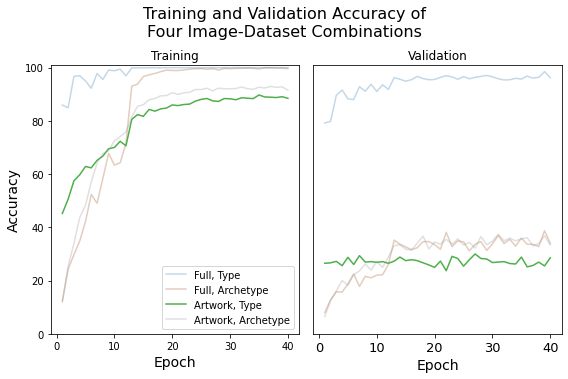

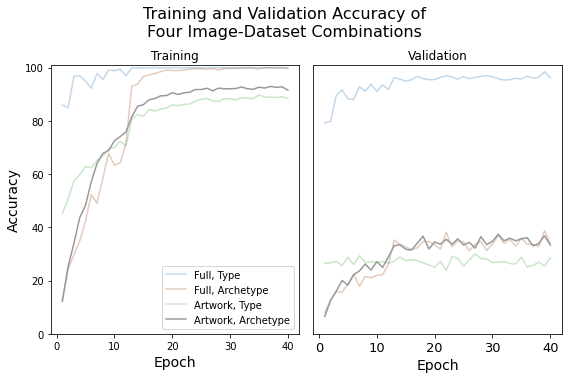

In [ ]:
#### Separate

j = 0
while j < 4:
  f, ax = plt.subplots(1, 2, figsize=(8, 5.5))
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  for i, out_obj in enumerate([out_ft, out_fa, out_at, out_aa]):
        if i==j:
          alp = 1
        else:
          alp = 0.3
      
        num_epochs = len(out_obj.train_acc_list)
        
        ax[0].plot(np.arange(1, num_epochs+1),
                out_obj.train_acc_list,
                label=name_list[i],
                alpha=alp,
                color=cols[i])
        ax[0].set_ylim([0, 101])
        ax[0].set_ylabel('Accuracy', fontsize=14)
        ax[0].set_xlabel("Epoch", fontsize=14)
        ax[0].legend(loc="lower right")
        ax[0].set_title("Training")

        ax[1].plot(np.arange(1, num_epochs+1),
                out_obj.valid_acc_list,
                label=name_list[i],
                alpha=alp,
                color=cols[i])
        ax[1].set_ylim([0, 101])
        ax[1].set_yticks([])
        ax[1].set_xlabel("Epoch", fontsize=14)
        ax[1].set_title("Validation")

  f.tight_layout(rect=[0, 0.03, 1, 0.9])
  f.suptitle("Training and Validation Accuracy of\nFour Image-Dataset Combinations", fontsize=16)
  plt.savefig(os.path.join(currentDir, "report", "figures", "accuracy"+str(j+1)+".pdf"))
  #f.show()
  j+=1